# Observer 20200504 ktrees

In [2]:

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import numpy as np
import math
import torchvision
from torchvision import transforms
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib
import matplotlib.pyplot as plt
from torch.optim.optimizer import required
from torch.utils.data.dataset import random_split
import scipy
import os
import glob
import pandas as pd
from hyperopt import hp, tpe, fmin, Trials
import pickle

% matplotlib inline

In [11]:
# Load data

loss_0 = np.load('../20200325/k_tree_loss_0.npy')
loss_1 = np.load('../20200325/k_tree_loss_1.npy')
loss_2 = np.load('../20200325/k_tree_loss_2.npy')
loss_3 = np.load('../20200325/k_tree_loss_3.npy')
loss_4 = np.load('../20200316/k_tree_acc.npy')

loss_1[1] = loss_3

loss = np.concatenate((loss_0,loss_1), 0)
loss = np.concatenate((loss,loss_2), 0)
loss = np.concatenate((loss,loss_4.reshape(1,10,6)), 0)

loss_0_64 = np.load('../20200325/k_tree_loss_0_64.npy')
loss_1_64 = np.load('../20200325/k_tree_loss_1_64.npy')
loss_2_64 = np.load('../20200325/k_tree_loss_2_64.npy')
# loss_4_64 = np.load('./k_tree_loss_4_64.npy')

loss_64 = np.concatenate((loss_0_64, loss_1_64), 0)
loss_64 = np.concatenate((loss_64, loss_2_64), 0)
# loss_64 = np.concatenate((loss_64, loss_4_64), 0)


# loss = np.concatenate((loss, loss_64), 2)

acc_0 = np.load('../20200325/k_tree_acc_0.npy')
acc_1 = np.load('../20200325/k_tree_acc_1.npy')
acc_2 = np.load('../20200325/k_tree_acc_2.npy')
acc_3 = np.load('../20200325/k_tree_acc_3.npy')
acc_4 = np.load('../20200316/k_tree_loss.npy')

acc_1[1] = acc_3

acc = np.concatenate((acc_0,acc_1), 0)
acc = np.concatenate((acc,acc_2), 0)
acc = np.concatenate((acc, acc_4.reshape(1,10,6)), 0)


acc_0_64 = np.load('../20200325/k_tree_acc_0_64.npy')
acc_1_64 = np.load('../20200325/k_tree_acc_1_64.npy')
acc_2_64 = np.load('../20200325/k_tree_acc_2_64.npy')
# acc_4_64 = np.load('./k_tree_acc_4_64.npy')

acc_64 = np.concatenate((acc_0_64, acc_1_64), 0)
acc_64 = np.concatenate((acc_64, acc_2_64), 0)
# acc_64 = np.concatenate((acc_64, acc_4_64), 0)


# acc = np.concatenate((acc, acc_64), 2)

acc_fc = np.load('../20200325/fc_acc.npy')
acc_fc_emnist = np.load('../20200325/fc_acc_emnist.npy')
acc_fc_cifar10 = np.load('../20200325/fc_acc_cifar10.npy')
acc_fc[3] = acc_fc_emnist
acc_fc = np.concatenate((acc_fc, acc_fc_cifar10), 0)

# acc_fc = np.load('./fc_acc.npy')


acc_lin = np.load('../20200325/lda_score_test.npy')
acc_lin_emnist = np.load('../20200325/lda_score_test_emnist.npy')
acc_lin_cifar10= np.load('../20200325/lda_score_test_cifar10.npy')
acc_lin[3] = acc_lin_emnist
acc_lin = np.concatenate((acc_lin, acc_lin_cifar10), 0)


rand_acc_0 = np.load('./k_tree_acc_0.npy')
rand_acc_1 = np.load('./k_tree_acc_1.npy')
rand_acc_2 = np.load('./k_tree_acc_2.npy')
rand_acc_3 = np.load('./k_tree_acc_3.npy')

rand_acc = np.concatenate((rand_acc_0,rand_acc_1), 0)
rand_acc = np.concatenate((rand_acc,rand_acc_2), 0)
rand_acc = np.concatenate((rand_acc, rand_acc_3.reshape(1,10,6)), 0)

In [15]:
rand_acc

array([[[0.47318612, 0.47055731, 0.3491062 , 0.69032597, 0.4511041 ,
         0.43638275],
        [0.46687697, 0.4915878 , 0.48107256, 0.47476341, 0.43480547,
         0.4679285 ],
        [0.47791798, 0.37276551, 0.48212408, 0.48054679, 0.53890641,
         0.53575184],
        [0.53995794, 0.51419558, 0.41640379, 0.36961094, 0.65667718,
         0.45846477],
        [0.61461619, 0.46109359, 0.46740273, 0.4831756 , 0.47108307,
         0.45425868],
        [0.46109359, 0.56414301, 0.39116719, 0.51629863, 0.44742376,
         0.54363828],
        [0.3617245 , 0.45373291, 0.55993691, 0.49789695, 0.45057834,
         0.48790747],
        [0.59831756, 0.52103049, 0.40273396, 0.45583596, 0.54942166,
         0.51472135],
        [0.48264984, 0.57570978, 0.46740273, 0.67139853, 0.52996845,
         0.51945321],
        [0.59568875, 0.45688749, 0.52155626, 0.56677182, 0.4384858 ,
         0.46529968]],

       [[0.5465    , 0.4965    , 0.4365    , 0.5005    , 0.4995    ,
         0.5       

In [7]:
# trees_set = [1,2,4,8,16,32, 64, 128]
trees_set = [1,2,4,8,16,32]

# ds_set = ['mnist','fmnist','kmnist','emnist','svhn','usps']
ds_set = ['MNIST','FMNIST','KMNIST','EMNIST','SVHN','USPS','CIFAR10']

In [25]:
classes = np.load('./classes.npy', allow_pickle=True)
classes

array([[3, 5, 'mnist'],
       [4, 6, 'fmnist'],
       [4, 9, 'kmnist'],
       [14, 17, 'emnist'],
       [6, 7, 'svhn'],
       [0, 1, 'usps'],
       [2, 3, 'cifar10']], dtype=object)

In [57]:
rand_idx = np.where(rand_acc[ds] > 0.50)
rand_idx = []

for i in range(10):
    if sum(rand_acc[ds, i]>0.50) == 6:
        rand_idx.append(i)

rand_idx

[1, 2, 5, 7, 8, 9]

n = 10
(6,)
(6,)
n = 22
(6,)
(6,)
lin n =  10
fc n =  10
1 : 0.9234 +/- 0.0120
2 : 0.9426 +/- 0.0062
4 : 0.9559 +/- 0.0072
8 : 0.9640 +/- 0.0036
16 : 0.9673 +/- 0.0030
32 : 0.9675 +/- 0.0028
lda: 0.8788 +/- 0.0086
fcnn: 0.9711 +/- 0.0118
1vlda: p = 0.0000
1vfcnn: p = 0.0000
1v32: p = 0.0000
2vfcnn: p = 0.0000
4vfcnn: p = 0.0042
8vfcnn: p = 0.1035
32vfcnn: p = 0.3930
ldavfcnn: p = 0.0000
0


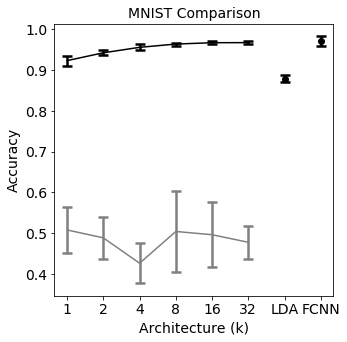

n = 10
(6,)
(6,)
n = 23
(6,)
(6,)
lin n =  10
fc n =  10
1 : 0.8051 +/- 0.0217
2 : 0.8175 +/- 0.0068
4 : 0.8385 +/- 0.0106
8 : 0.8449 +/- 0.0066
16 : 0.8557 +/- 0.0047
32 : 0.8641 +/- 0.0100
lda: 0.6849 +/- 0.0110
fcnn: 0.8880 +/- 0.0200
1vlda: p = 0.0000
1vfcnn: p = 0.0000
1v32: p = 0.0000
2vfcnn: p = 0.0000
4vfcnn: p = 0.0000
8vfcnn: p = 0.0000
32vfcnn: p = 0.0050
ldavfcnn: p = 0.0000
1


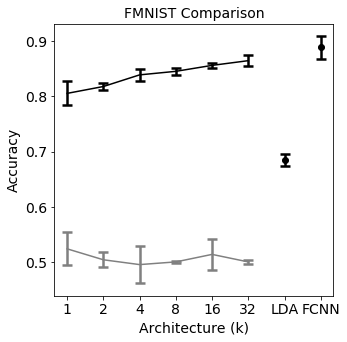

n = 10
(6,)
(6,)
n = 40
(6,)
(6,)
lin n =  10
fc n =  10
1 : 0.8193 +/- 0.0190
2 : 0.8578 +/- 0.0167
4 : 0.8829 +/- 0.0155
8 : 0.8961 +/- 0.0065
16 : 0.9079 +/- 0.0109
32 : 0.9035 +/- 0.0110
lda: 0.7087 +/- 0.0194
fcnn: 0.9720 +/- 0.0110
1vlda: p = 0.0000
1vfcnn: p = 0.0000
1v32: p = 0.0000
2vfcnn: p = 0.0000
4vfcnn: p = 0.0000
8vfcnn: p = 0.0000
32vfcnn: p = 0.0000
ldavfcnn: p = 0.0000
2


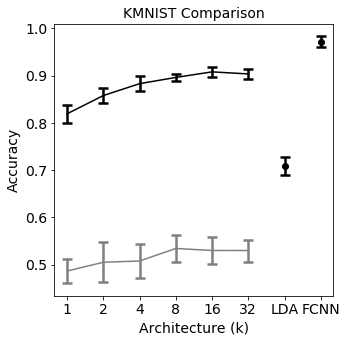

n = 10
(6,)
(6,)
n = 30
(6,)
(6,)
lin n =  10
fc n =  10
1 : 0.9586 +/- 0.0105
2 : 0.9699 +/- 0.0143
4 : 0.9813 +/- 0.0023
8 : 0.9837 +/- 0.0045
16 : 0.9848 +/- 0.0030
32 : 0.9859 +/- 0.0021
lda: 0.5886 +/- 0.0209
fcnn: 0.9883 +/- 0.0131
1vlda: p = 0.0000
1vfcnn: p = 0.0000
1v32: p = 0.0000
2vfcnn: p = 0.0107
4vfcnn: p = 0.1299
8vfcnn: p = 0.3286
32vfcnn: p = 0.5856
ldavfcnn: p = 0.0000
3


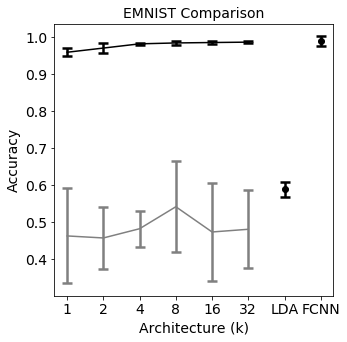

n = 10
(6,)
(6,)
n = 29
(6,)
(6,)
lin n =  10
fc n =  8
1 : 0.7043 +/- 0.0734
2 : 0.7359 +/- 0.0313
4 : 0.7593 +/- 0.0160
8 : 0.7767 +/- 0.0172
16 : 0.7816 +/- 0.0222
32 : 0.8073 +/- 0.0161
lda: 0.5278 +/- 0.0075
fcnn: 0.7500 +/- 0.1876
1vlda: p = 0.0000
1vfcnn: p = 0.5149
1v32: p = 0.0006
2vfcnn: p = 0.8280
4vfcnn: p = 0.8848
8vfcnn: p = 0.6789
32vfcnn: p = 0.3779
ldavfcnn: p = 0.0028
4


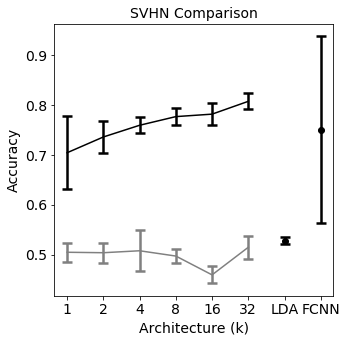

n = 10
(6,)
(6,)
n = 60
(6,)
(6,)
lin n =  10
fc n =  10
1 : 0.9719 +/- 0.0137
2 : 0.9848 +/- 0.0058
4 : 0.9894 +/- 0.0028
8 : 0.9891 +/- 0.0027
16 : 0.9899 +/- 0.0029
32 : 0.9900 +/- 0.0028
lda: 0.9059 +/- 0.0114
fcnn: 1.0000 +/- 0.0000
1vlda: p = 0.0000
1vfcnn: p = 0.0000
1v32: p = 0.0011
2vfcnn: p = 0.0000
4vfcnn: p = 0.0000
8vfcnn: p = 0.0000
32vfcnn: p = 0.0000
ldavfcnn: p = 0.0000
5


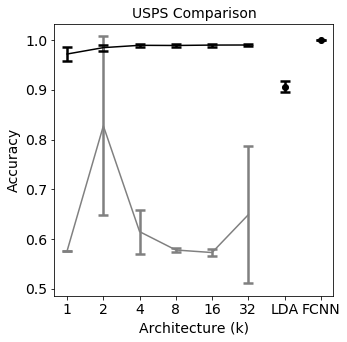

n = 10
(6,)
(6,)
n = 56
(6,)
(6,)
lin n =  10
fc n =  9
1 : 0.6385 +/- 0.0095
2 : 0.6421 +/- 0.0100
4 : 0.6575 +/- 0.0105
8 : 0.6651 +/- 0.0095
16 : 0.6757 +/- 0.0118
32 : 0.6813 +/- 0.0104
lda: 0.5796 +/- 0.0119
fcnn: 0.6550 +/- 0.0796
1vlda: p = 0.0000
1vfcnn: p = 0.5465
1v32: p = 0.0000
2vfcnn: p = 0.6356
4vfcnn: p = 0.9284
8vfcnn: p = 0.7124
32vfcnn: p = 0.3403
ldavfcnn: p = 0.0123
6


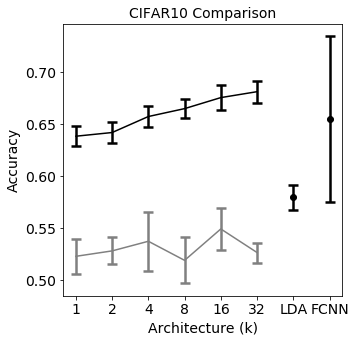

In [62]:

for ds, ds_name in enumerate(ds_set):

    fig, ax = plt.subplots(figsize=(5,5))

    x = np.arange(len(trees_set))

    idx = np.where(acc[ds,:,-1] != 0)[-1]
    print('n =',len(idx))
    acc_mean = np.mean(acc[ds,idx,:], axis=0)
    print(acc_mean.shape)
    acc_std = np.std(acc[ds,idx,:], axis=0)
    print(acc_std.shape)

    ax.errorbar(x, acc_mean, yerr=acc_std, capsize=5, capthick=2.5, elinewidth=2.5, c='black')
    
    rand_idx = np.where(rand_acc[ds,:,:] > 0.50)[-1]
    print('n =',len(rand_idx))
    rand_acc_mean = np.mean(rand_acc[ds,rand_idx,:], axis=0)
    print(rand_acc_mean.shape)
    rand_acc_std = np.std(rand_acc[ds,rand_idx,:], axis=0)
    print(rand_acc_std.shape)

    ax.errorbar(x, rand_acc_mean, yerr=rand_acc_std, capsize=5, capthick=2.5, elinewidth=2.5, c='grey')


    idxl = np.where(acc_lin[ds,:] > 0.50)[0]
    print('lin n = ', len(idxl))
    acc_lin_mean = np.mean(acc_lin[ds,idxl])
    acc_lin_std = np.std(acc_lin[ds,idxl])
    ax.errorbar(6, acc_lin_mean, yerr=acc_lin_std, capsize=5, fmt='o', capthick=2.5, elinewidth=2.5, c='black')


    idxf = np.where(acc_fc[ds,:] > 0.50)[0]
    print('fc n = ', len(idxf))
    acc_fc_mean = np.mean(acc_fc[ds,idxf])
    acc_fc_std = np.std(acc_fc[ds,idxf])
    ax.errorbar(7, acc_fc_mean, yerr=acc_fc_std, capsize=5, fmt='o', capthick=2.5, elinewidth=2.5, c='black')

    ax.set_xticks(np.arange(len(trees_set)+2))
    ax.set_xticklabels(np.concatenate((trees_set,['LDA'],['FCNN']),0), fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Architecture (k)', fontsize=14)
    plt.yticks(fontsize=14)

    ax.set_title(ds_name+' Comparison', fontsize=14)
#     ax.legend(['ktrees','linear (lda)','fcnn'])

    for j, n_tree in enumerate(trees_set):
        print('%s : %.4f +/- %.4f' % (n_tree, acc_mean[j], acc_std[j]))
        
    print('lda: %.4f +/- %.4f' % (acc_lin_mean, acc_lin_std))
    print('fcnn: %.4f +/- %.4f' % (acc_fc_mean, acc_fc_std))
    

    _, compare_1vlda = scipy.stats.ttest_ind(acc[ds,idx,0], acc_lin[ds,idxl])
    print('1vlda: p = %.4f' % compare_1vlda)
    _, compare_1vfcnn = scipy.stats.ttest_ind(acc[ds,idx,0], acc_fc[ds,idxf])
    print('1vfcnn: p = %.4f' % compare_1vfcnn)
    _, compare_1v32 = scipy.stats.ttest_ind(acc[ds,idx,0], acc[ds,idx,5])
    print('1v32: p = %.4f' % compare_1v32)
    _, compare_2vfcnn = scipy.stats.ttest_ind(acc[ds,idx,1], acc_fc[ds,idxf])
    print('2vfcnn: p = %.4f' % compare_2vfcnn)
    _, compare_4vfcnn = scipy.stats.ttest_ind(acc[ds,idx,2], acc_fc[ds,idxf])
    print('4vfcnn: p = %.4f' % compare_4vfcnn)
    _, compare_8vfcnn = scipy.stats.ttest_ind(acc[ds,idx,3], acc_fc[ds,idxf])
    print('8vfcnn: p = %.4f' % compare_8vfcnn)
    _, compare_32vfcnn = scipy.stats.ttest_ind(acc[ds,idx,5], acc_fc[ds,idxf])
    print('32vfcnn: p = %.4f' % compare_32vfcnn)
    _, compare_ldavfcnn = scipy.stats.ttest_ind(acc_lin[ds,idxl], acc_fc[ds,idxf])
    print('ldavfcnn: p = %.4f' % compare_ldavfcnn)
    print(ds)
    
    plt.savefig(ds_name+'_rand.svg', format='svg')
    
    plt.show()


In [14]:
ds = 4
print(ds_set[4])
_, compare_32vfcnn = scipy.stats.ttest_ind(acc[ds,idx,4], acc_fc[ds,:])
print('32vfcnn: p = %.4f' % compare_32vfcnn)
print('%.4f +/- %.4f \n%.4f +/- %.4f' % (np.mean(acc[ds,idx,4], axis=0), 
                                         np.std(acc[ds,idx,4], axis=0),
                                         np.mean(acc_fc[ds,:], axis=0),
                                         np.std(acc_fc[ds,:], axis=0)))
print(acc_fc[ds])

svhn
32vfcnn: p = 0.2163
0.7816 +/- 0.0222 
0.6957 +/- 0.1999
[0.47619048 0.9047619  0.50125313 0.48120301 0.88220551 0.89473684
 0.90225564 0.89223058 0.50877193 0.51378446]


n = 10
()
()
1: 0.9234 +/- 0.0120
lda: 0.8788 +/- 0.0086
fcnn: 0.9711 +/- 0.0118


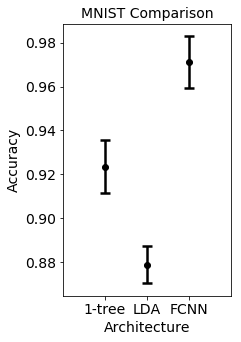

n = 10
()
()
1: 0.8051 +/- 0.0217
lda: 0.6849 +/- 0.0110
fcnn: 0.8880 +/- 0.0200


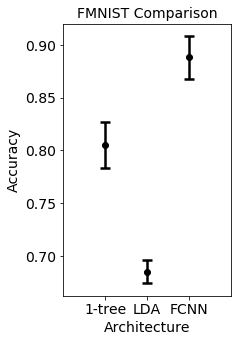

n = 10
()
()
1: 0.8193 +/- 0.0190
lda: 0.7087 +/- 0.0194
fcnn: 0.9720 +/- 0.0110


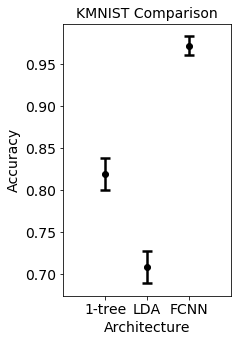

n = 10
()
()
1: 0.9586 +/- 0.0105
lda: 0.5886 +/- 0.0209
fcnn: 0.9883 +/- 0.0131


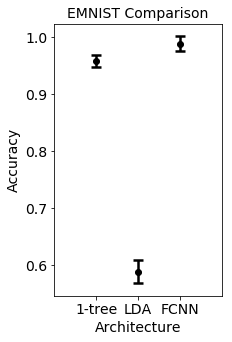

n = 10
()
()
1: 0.7043 +/- 0.0734
lda: 0.5278 +/- 0.0075
fcnn: 0.7500 +/- 0.1876


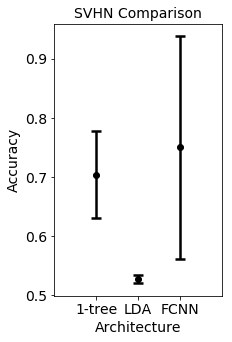

n = 10
()
()
1: 0.9719 +/- 0.0137
lda: 0.9059 +/- 0.0114
fcnn: 1.0000 +/- 0.0000


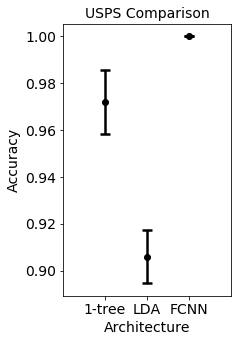

n = 10
()
()
1: 0.6385 +/- 0.0095
lda: 0.5796 +/- 0.0119
fcnn: 0.6550 +/- 0.0796


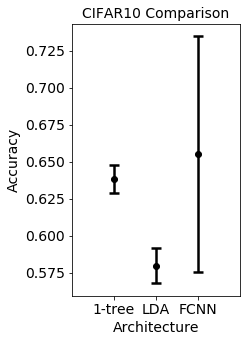

In [58]:

for ds, ds_name in enumerate(ds_set):


    fig, ax = plt.subplots(figsize=(3,5))
    
    x = [0]


    idx = np.where(acc[ds,:,-1] != 0)[-1]
    print('n =',len(idx))
    acc_mean = np.mean(acc[ds,idx,0], axis=0)
    print(acc_mean.shape)
    acc_std = np.std(acc[ds,idx,0], axis=0)
    print(acc_std.shape)

    ax.errorbar(1, acc_mean, yerr=acc_std, capsize=5, fmt='o', capthick=2.5, elinewidth=2.5, c='black')


    idx = np.where(acc_lin[ds,:] > 0.50)[0]
    acc_lin_mean = np.mean(acc_lin[ds,idx])
    acc_lin_std = np.std(acc_lin[ds,idx])
    ax.errorbar(2, acc_lin_mean, yerr=acc_lin_std, capsize=5, fmt='o', capthick=2.5, elinewidth=2.5, c='black')


    idx = np.where(acc_fc[ds,:] > 0.50)[0]
    acc_fc_mean = np.mean(acc_fc[ds,idx])
    acc_fc_std = np.std(acc_fc[ds,idx])
    ax.errorbar(3, acc_fc_mean, yerr=acc_fc_std, capsize=5, fmt='o', capthick=2.5, elinewidth=2.5, c='black')

    ax.set_xticks([1,2,3])
    ax.set_xticklabels(['1-tree', 'LDA','FCNN'], fontsize=14)
    plt.yticks(fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_xlabel('Architecture', fontsize=14)

    ax.set_xlim(left=0, right=4)
    ax.set_title(ds_name+' Comparison', fontsize=14)
#     ax.legend(['1-tree','linear (lda)','fcnn'])
    
    print('1: %.4f +/- %.4f' % (acc_mean, acc_std))
    print('lda: %.4f +/- %.4f' % (acc_lin_mean, acc_lin_std))
    print('fcnn: %.4f +/- %.4f' % (acc_fc_mean, acc_fc_std))
    
    plt.savefig(ds_name+'_single.svg', format='svg')
    
    plt.show()


In [63]:
torch.__version__

'1.4.0'

In [64]:
torchvision.__version__

'0.5.0'

In [66]:
import sklearn
sklearn.__version__

'0.19.2'

In [ ]:
class simple_fcnn(nn.Module):
    '''
    2 layer feed forward neural network. 
    Will code in Linear, Sigmoid, or ReLU activation functions.
    Activation = {'relu', 'sigmoid', 'linear'}
    '''
    
    def __init__(self, Input_size=3072, Hidden_size=3072, Output_size=1, Activation="relu"):
        super(simple_fcnn, self).__init__()
        '''
        Inputs: Input_size, Hidden_size, Output_size
        '''
        # Initialize architecture parameters
        self.Input_size = Input_size
        self.Hidden_size = Hidden_size
        self.Output_size = Output_size
        self.Activation = Activation
        
        
        # Initialize weights through He initialization (by default in nn.Linear)
        
        self.i2h = nn.Linear(Input_size, Hidden_size, bias=True)
        self.i2h.bias = torch.nn.Parameter(torch.zeros_like(self.i2h.bias))
#         self.i2h.weight = torch.nn.init.normal_(self.i2h.weight, mean=0.0, std=math.sqrt(2/(Input_size)))
        self.i2h.weight = torch.nn.init.kaiming_normal_(self.i2h.weight, a=0.01)


        # Initialize densly connected output layer
        self.h2o = nn.Linear(Hidden_size, Output_size)
        self.h2o.bias = torch.nn.Parameter(torch.zeros_like(self.h2o.bias))
        self.h2o.weight = torch.nn.init.kaiming_normal_(self.h2o.weight, a=0.01)
        
        # Initialize nonlinearities
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        '''
        Forward step for network. Establishes Architecture.
        Inputs: Input, Hidden
        Outputs: Output, Hidden
        '''
        # Prepare input for appropriate architecture

        
        # Set Activation function to calculate hidden layer

        if self.Activation == 'relu':
            Hidden = self.relu(self.i2h(x))
        else:
            Hidden = self.i2h(x)

        # Calculate Output layer
        Output = self.sigmoid(self.h2o(Hidden))
        return(Output)